In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob 
import pickle
import json

from math import radians, cos, sin 
from tqdm import tqdm
from easydict import EasyDict
from geographiclib.geodesic import Geodesic

np.set_printoptions(suppress=True, precision=5)

In [62]:
AIRPORT = "kmsy"
BASE_DIR = f'../datasets/amelia/traj_data_a10v7/proc_trajectories/{AIRPORT}'

ref_file = f"../datasets/amelia/assets/{AIRPORT}/limits.json"
with open(ref_file, 'r') as f:
    ref_data = EasyDict(json.load(f))
ref = [ref_data.ref_lat, ref_data.ref_lon, ref_data.range_scale]

scenarios_list = glob.glob(f"{BASE_DIR}/**/*.pkl", recursive=True)

In [64]:
RAW_SEQ_IDX = EasyDict({
    'Altitude': 0, 'Speed': 1, 'Heading': 2, 'Lat': 3, 'Lon': 4, 'Range': 5, 'Bearing': 6,  
    'Interp': 7, 'x': 8, 'y': 9
})
# Swapped order to go...
# From: Altitude, Speed, Heading, Lat, Lon, Range, Bearing, Interp, x, y
#   To: Speed, Heading, Lat, Lon, Range, Bearing, Interp, x, y, z
# SEQ_ORDER = [1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
SEQ_ORDER = [
    RAW_SEQ_IDX.Speed, RAW_SEQ_IDX.Heading, RAW_SEQ_IDX.Lat, RAW_SEQ_IDX.Lon, RAW_SEQ_IDX.Range,
    RAW_SEQ_IDX.Bearing, RAW_SEQ_IDX.Interp, RAW_SEQ_IDX.x, RAW_SEQ_IDX.y, RAW_SEQ_IDX.Altitude
]
# Final index order after post-processing: 
#   Speed, Heading, Lat, Lon, Range, Bearing, Interp, x, y, z (Previously Altitude)
SEQ_IDX = EasyDict({
    'Speed': 0, 'Heading': 1, 'Lat': 2, 'Lon': 3, 'Range': 4, 'Bearing': 5, 'Interp': 6, 
    'x': 7, 'y': 8, 'z': 9, 
})

DIM = len(RAW_SEQ_IDX.keys())

# Agent types
AGENT_TYPES = {'Aircraft': 0, 'Vehicle': 1, 'Unknown': 2}

# A bit overkill, but it's to avoid indexing errors. 
# Traj Masks
LL = np.zeros(shape=len(SEQ_ORDER)).astype(bool)
LL[SEQ_IDX.Lat] = LL[SEQ_IDX.Lon] = True

HLL = np.zeros(shape=len(SEQ_ORDER)).astype(bool)
HLL[SEQ_IDX.Lat] = HLL[SEQ_IDX.Lon] = HLL[SEQ_IDX.Heading] = True

HD = np.zeros(shape=len(SEQ_ORDER)).astype(bool)
HD[SEQ_IDX.Heading] = True

XY = np.zeros(shape=len(SEQ_ORDER)).astype(bool)
XY[SEQ_IDX.x] = XY[SEQ_IDX.y] = True

XYZ = np.zeros(shape=len(SEQ_ORDER)).astype(bool)
XYZ[SEQ_IDX.x] = XYZ[SEQ_IDX.y] = XYZ[SEQ_IDX.z] = True

REL_XY  = [ True,  True, False, False]
# REL_XY  = [ True,  True, False]
REL_XYZ = [ True,  True,  True, False]
REL_HD  = [False, False, False,  True]

HIST_LEN = 10

geodesic = Geodesic.WGS84

In [66]:
def wrap_angle(angle):
    return np.radians(((angle % 360) + 540) % 360 - 180)

def transform_sequences(sequences: np.array, ego_agent_id: int = 0, hist_len: int = 10) -> np.array:
    num_agents, timesteps, _ = sequences.shape
    rel_sequence = np.zeros(shape=(num_agents, timesteps, 4)) # [x, y, z, heading]
    curr_idx = hist_len -1 

    # the ego-agent's heading at the 'current time step'
    ego_heading = radians(sequences[ego_agent_id, curr_idx, SEQ_IDX.Heading])

    R = np.array(
        [[cos(ego_heading), -sin(ego_heading), 0.0],
         [sin(ego_heading),  cos(ego_heading), 0.0],
         [             0.0,               0.0, 1.0]])
    R = np.repeat(R.reshape(1, 3, 3), num_agents, axis=0)

    rel_xyz = sequences[:, :, XYZ] - sequences[ego_agent_id, curr_idx, XYZ]
    rel_sequence[:, :, :3] = np.matmul(rel_xyz, R)
    # rel_xy = sequences[:, :, C.XY] - sequences[ego_agent_id, curr_idx, C.XY]
    # rel_sequence[:, :, :2] = np.matmul(rel_xy, R)

    headings = sequences[:, :, SEQ_IDX.Heading]
    ego_heading = sequences[ego_agent_id, curr_idx, SEQ_IDX.Heading]

    # wrap the angle
    rel_sequence[:, :, -1] = wrap_angle(headings - ego_heading)
    return rel_sequence

def transform(traj_rel: np.array, start_abs: np.array, theta: float) -> np.array:
    heading = radians(theta)
    # heading = -radians(theta)
    R = np.array(
        [[cos(heading), -sin(heading)], 
         [sin(heading),  cos(heading)]])
    rot_coords = traj_rel @ R.T 
    return rot_coords + start_abs

def direct_wrapper(geodesic, b, r, ref_lat, ref_lon, r_scale):
    lat_array = []
    lon_array = []
    for i in range(r.shape[0]):
        g = geodesic.Direct(ref_lat, ref_lon, b[i], r[i] * r_scale)
        lat_array.append(g['lat2'])
        lon_array.append(g['lon2'])
    return np.asarray(lat_array), np.asarray(lon_array)

def xy_to_ll(traj_rel, start_abs_xy, start_heading, reference, geodesic) -> np.array:
    N, _ , _ = traj_rel.shape
    traj_ll = np.zeros_like(traj_rel)
    traj_xy_abs = transform(traj_rel, start_abs_xy, start_heading)

    for n in range(N):
        x, y = traj_xy_abs[n, :, 0], traj_xy_abs[n, :, 1]
        rang = np.sqrt(x ** 2 + y ** 2)
        bearing = np.degrees(np.arctan2(y, x))
        # lat, lon
        lat, lon = direct_wrapper(geodesic, bearing, rang, reference[0], reference[1], reference[2])
        traj_ll[n , :, 1] = lon 
        traj_ll[n , :, 0] = lat
    return traj_ll

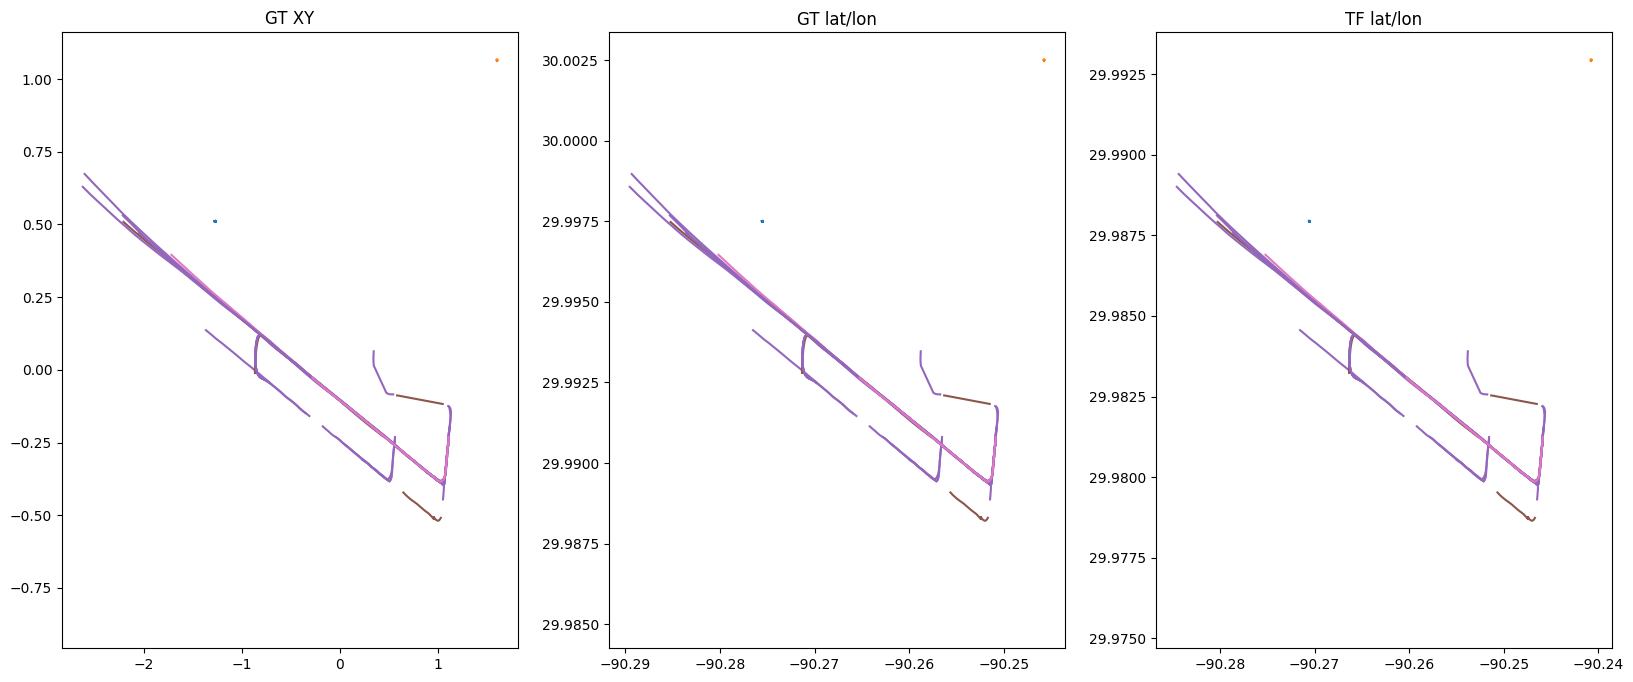

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

for i, scenario_file in enumerate(scenarios_list):
    if i > 100:
        break
    with open(scenario_file,'rb') as f:
        scene = pickle.load(f)
    
    sequences = scene['sequences']
    gt_xy = sequences[:, :, XY]
    gt_ll = sequences[:, :, LL]

    ego_id = 0
    rel_sequence = transform_sequences(sequences, ego_agent_id=ego_id, hist_len=HIST_LEN)[:, :, REL_XY]
    
    start_xy = gt_xy[ego_id, HIST_LEN-1]
    start_heading = sequences[ego_id, HIST_LEN-1, HD]

    tf_ll = xy_to_ll(rel_sequence, start_xy, start_heading, ref, geodesic)
    
    for n in range(gt_xy.shape[0]):
        ax[0].plot(gt_xy[n, :, 1], gt_xy[n, :, 0], color=f"C{n % 10}")
        ax[0].set_title('GT XY')

        ax[1].plot(gt_ll[n, :, 1], gt_ll[n, :, 0], color=f"C{n % 10}")
        ax[1].set_title('GT lat/lon')

        ax[2].plot(tf_ll[n, :, 1], tf_ll[n, :, 0], color=f"C{n % 10}")
        ax[2].set_title('TF lat/lon')
    
    


    
